# fashion_mnist 이미지 분류하기
- 데이터셋:torchvision 내장데이터셋 fashion_mnist
- 목적: 이미지 분류하기
- 피쳐: 28*28 픽셀
- 타겟: labels (0~9)
- 학습방법: 딥러닝
- 알고리즘: DNN, CNN
- 프레임워크 : Pytorch

[1] 모듈 로딩

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 모델 설계를 위한 모듈
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

# 데이터 전처리를 위한 라이브러리
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
# 데이터 로딩
train_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True, train=False,transform=transforms.Compose([transforms.ToTensor()]))

100.0%


Extracting ../chap05/data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../chap05/data\FashionMNIST\raw



100.0%


Extracting ../chap05/data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../chap05/data\FashionMNIST\raw



100.0%


Extracting ../chap05/data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../chap05/data\FashionMNIST\raw



100.0%

Extracting ../chap05/data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../chap05/data\FashionMNIST\raw



In [9]:
import torch.utils


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

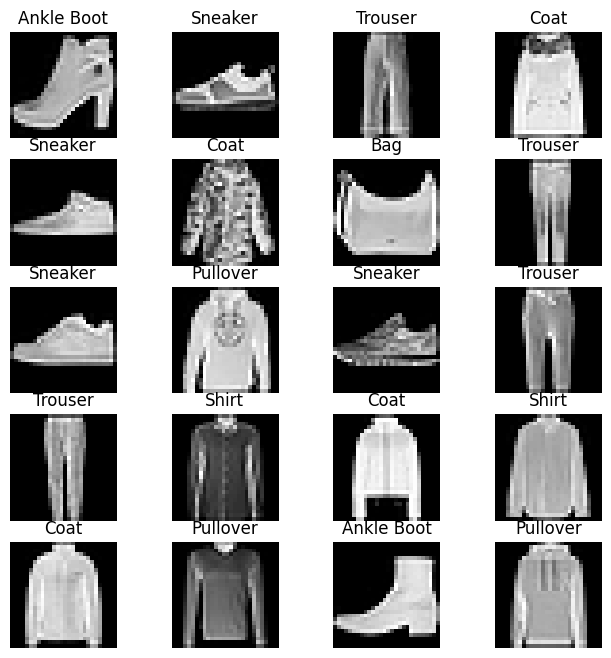

In [6]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 :'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows =5
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

[2] DNN 모델 생성

In [7]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)  # 입력층 784   출력층 256
        self.drop = nn.Dropout(0.25)                             # 드랍아웃 과대적합 방지
        self.fc2 = nn.Linear(in_features=256, out_features=128)  # 입력층 256   출력층 128
        self.fc3 = nn.Linear(in_features=128, out_features=10)   # 입력층 128   출력층 10
    
    def forward(self, input_data):
        out = input_data.view(-1, 784)    # torch가 알아서 바꿔준다
        out = F.relu(self.fc1(out))
        out= self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [8]:
# 학습관련
learing_rate = 0.001

# 모델 객체생성
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss() #분류에서 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


[3]모델 학습

In [10]:
num_epochs = 5 
count =0

loss_list = []
iteration_list =[]
accuracy_list = []

predictions_list =[]
labels_list =[]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        
        # 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count +=1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1,28,28))
                outputs=model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy= correct *100 /total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.6016823053359985, Accuracy: 83.47999572753906%
Iteration: 1000, Loss: 0.43109235167503357, Accuracy: 84.5%
Iteration: 1500, Loss: 0.3600401282310486, Accuracy: 84.04999542236328%
Iteration: 2000, Loss: 0.457556813955307, Accuracy: 85.75999450683594%
Iteration: 2500, Loss: 0.3105180263519287, Accuracy: 86.12999725341797%
Iteration: 3000, Loss: 0.34227702021598816, Accuracy: 87.04999542236328%


[4] CNN 모델 생성

In [23]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # same padding   # in_channels = 1인건 회색하나만 들어가서이다 ,  RGB를 가졌으면 3
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # 이미지크기를 축소, 
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) , # valid padding
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # fully connection
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)  # 오류때문에 drout으로 바꿔줌
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10) # 클래스 10개 분류

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # 평탄화
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [24]:
# 학습 관련 파라미터 정의
learing_rate = 0.001

# 모델 객체 생성
CNNmodel = FashionCNN()
CNNmodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=learing_rate)
print(CNNmodel)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


[5] 학습 및 모델 성능평가

학습 및 모델 성능평가 함수

In [25]:
num_epochs = 5 
count =0

loss_list = []
iteration_list =[]
accuracy_list = []

predictions_list =[]
labels_list =[]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = CNNmodel(train)
        loss = criterion(outputs, labels)
        
        # 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count +=1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1,28,28))
                outputs=CNNmodel(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy= correct *100 /total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5175489187240601, Accuracy: 87.6199951171875%
Iteration: 1000, Loss: 0.3359009921550751, Accuracy: 87.63999938964844%
Iteration: 1500, Loss: 0.24571065604686737, Accuracy: 89.61000061035156%
Iteration: 2000, Loss: 0.2180151343345642, Accuracy: 89.50999450683594%
Iteration: 2500, Loss: 0.14247995615005493, Accuracy: 89.72999572753906%
Iteration: 3000, Loss: 0.1896132230758667, Accuracy: 90.40999603271484%
